## Using Cifar10 to create a working image classification model and then creating a web application using FastAPI

In [1]:
# import dependencies
import random
import os
import keras
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfd
from tensorflow.keras import layers
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Conv2DTranspose, BatchNormalization, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import numpy

In [2]:
# load data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [3]:
# Checking the shapes of all the data

x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [4]:
# Dividing the pixel values so i can help the model to train more efficiently
x_train, x_test = x_train/255., x_test/255. 
x_train[:1]

array([[[[0.23137255, 0.24313725, 0.24705882],
         [0.16862745, 0.18039216, 0.17647059],
         [0.19607843, 0.18823529, 0.16862745],
         ...,
         [0.61960784, 0.51764706, 0.42352941],
         [0.59607843, 0.49019608, 0.4       ],
         [0.58039216, 0.48627451, 0.40392157]],

        [[0.0627451 , 0.07843137, 0.07843137],
         [0.        , 0.        , 0.        ],
         [0.07058824, 0.03137255, 0.        ],
         ...,
         [0.48235294, 0.34509804, 0.21568627],
         [0.46666667, 0.3254902 , 0.19607843],
         [0.47843137, 0.34117647, 0.22352941]],

        [[0.09803922, 0.09411765, 0.08235294],
         [0.0627451 , 0.02745098, 0.        ],
         [0.19215686, 0.10588235, 0.03137255],
         ...,
         [0.4627451 , 0.32941176, 0.19607843],
         [0.47058824, 0.32941176, 0.19607843],
         [0.42745098, 0.28627451, 0.16470588]],

        ...,

        [[0.81568627, 0.66666667, 0.37647059],
         [0.78823529, 0.6       , 0.13333333]

In [5]:
# Flattening the labels 
y_test, y_train = y_test.flatten(), y_train.flatten()

In [6]:
y_test.shape, y_train.shape

((10000,), (50000,))

In [7]:
#creating the classes for predictions
cifar10_classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Text(0.5, 1.0, 'frog')

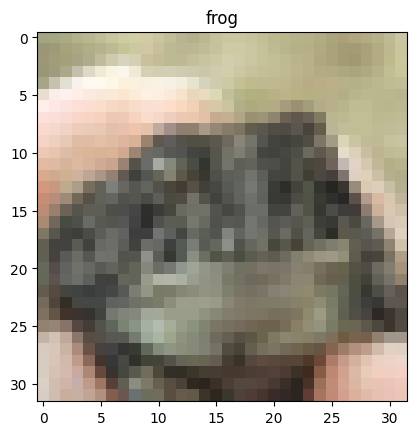

In [8]:
# Checking a sample picture 

plt.imshow(x_train[25])
plt.title(cifar10_classes[y_train[25]])

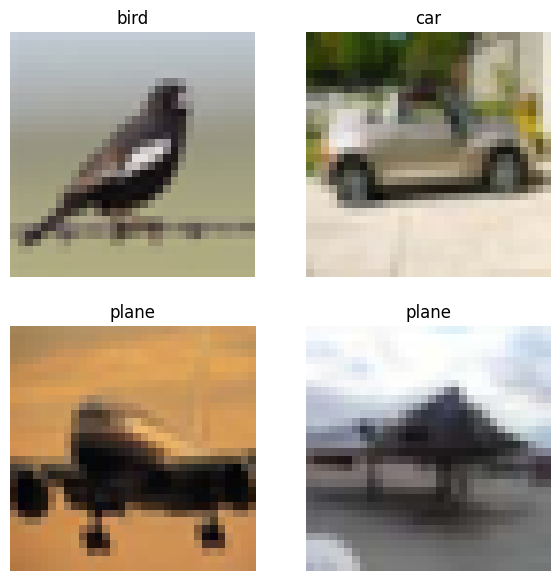

In [9]:

plt.figure(figsize=(7, 7))
for i in range(4):
    ax = plt.subplot(2 ,2 , i +1)
    rand_index = random.choice(range(len(x_train)))
    plt.imshow(x_train[rand_index], cmap=plt.cm.binary)
    plt.title(cifar10_classes[y_train[rand_index]])
    plt.axis(False)

In [10]:
# Creating modelcheckpoint callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

path = "modelcheckpoint/"

modelcheckpoint = ModelCheckpoint(filepath=path, 
                                  monitor="val_accuracy",
                                  save_best_only=True,
                                  save_weights_only=False,
                                  save_freq="epoch")


early_stopping = EarlyStopping(monitor="val_loss", patience=2 )

In [11]:
x_train[1].shape, x_train[1]

((32, 32, 3),
 array([[[0.60392157, 0.69411765, 0.73333333],
         [0.49411765, 0.5372549 , 0.53333333],
         [0.41176471, 0.40784314, 0.37254902],
         ...,
         [0.35686275, 0.37254902, 0.27843137],
         [0.34117647, 0.35294118, 0.27843137],
         [0.30980392, 0.31764706, 0.2745098 ]],
 
        [[0.54901961, 0.62745098, 0.6627451 ],
         [0.56862745, 0.6       , 0.60392157],
         [0.49019608, 0.49019608, 0.4627451 ],
         ...,
         [0.37647059, 0.38823529, 0.30588235],
         [0.30196078, 0.31372549, 0.24313725],
         [0.27843137, 0.28627451, 0.23921569]],
 
        [[0.54901961, 0.60784314, 0.64313725],
         [0.54509804, 0.57254902, 0.58431373],
         [0.45098039, 0.45098039, 0.43921569],
         ...,
         [0.30980392, 0.32156863, 0.25098039],
         [0.26666667, 0.2745098 , 0.21568627],
         [0.2627451 , 0.27058824, 0.21568627]],
 
        ...,
 
        [[0.68627451, 0.65490196, 0.65098039],
         [0.61176471, 0.603

In [12]:
y_train.shape, x_train.shape

((50000,), (50000, 32, 32, 3))

In [13]:
train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train.cache().shuffle(buffer_size=100)
train_data = train_data.batch(128).prefetch(buffer_size=tf.data.AUTOTUNE)


In [14]:
test = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_data = test.cache().shuffle(buffer_size=100)
test_data = test_data.batch(128).prefetch(buffer_size=tf.data.AUTOTUNE)

In [15]:
# Building a CNN model

model = Sequential([
    Conv2D(16, 3, padding="same", activation="relu",input_shape=(32,32,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Conv2D(64, 3, padding="same", activation="relu"),
    MaxPooling2D(),
    Flatten(),
    Dense(32, activation="relu"),
    Dense(10, activation="softmax")
], name="model")


In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0     

In [17]:
model.compile(loss=SparseCategoricalCrossentropy(),
                  optimizer = Adam(),
                  metrics=["accuracy"])
    
history = model.fit(train_data, epochs=15, validation_data=test_data,
                        callbacks=[modelcheckpoint, early_stopping])
    

Epoch 1/15
390/391 [============================>.] - ETA: 0s - loss: 1.6695 - accuracy: 0.3971

INFO:tensorflow:Assets written to: modelcheckpoint\assets


INFO:tensorflow:Assets written to: modelcheckpoint\assets


391/391 [==============================] - 21s 51ms/step - loss: 1.6692 - accuracy: 0.3972 - val_loss: 1.3734 - val_accuracy: 0.5070
Epoch 2/15
391/391 [==============================] - ETA: 0s - loss: 1.3087 - accuracy: 0.5339

INFO:tensorflow:Assets written to: modelcheckpoint\assets


INFO:tensorflow:Assets written to: modelcheckpoint\assets


391/391 [==============================] - 20s 50ms/step - loss: 1.3087 - accuracy: 0.5339 - val_loss: 1.2003 - val_accuracy: 0.5811
Epoch 3/15
390/391 [============================>.] - ETA: 0s - loss: 1.1613 - accuracy: 0.5918

INFO:tensorflow:Assets written to: modelcheckpoint\assets


INFO:tensorflow:Assets written to: modelcheckpoint\assets


391/391 [==============================] - 20s 51ms/step - loss: 1.1614 - accuracy: 0.5918 - val_loss: 1.0976 - val_accuracy: 0.6190
Epoch 4/15
391/391 [==============================] - 20s 50ms/step - loss: 1.0731 - accuracy: 0.6237 - val_loss: 1.1023 - val_accuracy: 0.6155
Epoch 5/15
390/391 [============================>.] - ETA: 0s - loss: 1.0021 - accuracy: 0.6515

INFO:tensorflow:Assets written to: modelcheckpoint\assets


INFO:tensorflow:Assets written to: modelcheckpoint\assets


391/391 [==============================] - 20s 51ms/step - loss: 1.0022 - accuracy: 0.6515 - val_loss: 1.0063 - val_accuracy: 0.6533
Epoch 6/15
390/391 [============================>.] - ETA: 0s - loss: 0.9361 - accuracy: 0.6748

INFO:tensorflow:Assets written to: modelcheckpoint\assets


INFO:tensorflow:Assets written to: modelcheckpoint\assets


391/391 [==============================] - 20s 52ms/step - loss: 0.9363 - accuracy: 0.6748 - val_loss: 0.9564 - val_accuracy: 0.6678
Epoch 7/15
390/391 [============================>.] - ETA: 0s - loss: 0.8885 - accuracy: 0.6924

INFO:tensorflow:Assets written to: modelcheckpoint\assets


INFO:tensorflow:Assets written to: modelcheckpoint\assets


391/391 [==============================] - 20s 51ms/step - loss: 0.8884 - accuracy: 0.6925 - val_loss: 0.9536 - val_accuracy: 0.6699
Epoch 8/15
391/391 [==============================] - ETA: 0s - loss: 0.8486 - accuracy: 0.7075

INFO:tensorflow:Assets written to: modelcheckpoint\assets


INFO:tensorflow:Assets written to: modelcheckpoint\assets


391/391 [==============================] - 20s 50ms/step - loss: 0.8486 - accuracy: 0.7075 - val_loss: 0.9234 - val_accuracy: 0.6796
Epoch 9/15
390/391 [============================>.] - ETA: 0s - loss: 0.8114 - accuracy: 0.7208

INFO:tensorflow:Assets written to: modelcheckpoint\assets


INFO:tensorflow:Assets written to: modelcheckpoint\assets


391/391 [==============================] - 20s 51ms/step - loss: 0.8112 - accuracy: 0.7209 - val_loss: 0.9069 - val_accuracy: 0.6895
Epoch 10/15
390/391 [============================>.] - ETA: 0s - loss: 0.7828 - accuracy: 0.7338

INFO:tensorflow:Assets written to: modelcheckpoint\assets


INFO:tensorflow:Assets written to: modelcheckpoint\assets


391/391 [==============================] - 21s 53ms/step - loss: 0.7832 - accuracy: 0.7336 - val_loss: 0.8827 - val_accuracy: 0.6970
Epoch 11/15
391/391 [==============================] - ETA: 0s - loss: 0.7531 - accuracy: 0.7426

INFO:tensorflow:Assets written to: modelcheckpoint\assets


INFO:tensorflow:Assets written to: modelcheckpoint\assets


391/391 [==============================] - 21s 53ms/step - loss: 0.7531 - accuracy: 0.7426 - val_loss: 0.8706 - val_accuracy: 0.7023
Epoch 12/15
391/391 [==============================] - ETA: 0s - loss: 0.7290 - accuracy: 0.7503

INFO:tensorflow:Assets written to: modelcheckpoint\assets


INFO:tensorflow:Assets written to: modelcheckpoint\assets


391/391 [==============================] - 34s 86ms/step - loss: 0.7290 - accuracy: 0.7503 - val_loss: 0.8660 - val_accuracy: 0.7050
Epoch 13/15
391/391 [==============================] - ETA: 0s - loss: 0.7075 - accuracy: 0.7582

INFO:tensorflow:Assets written to: modelcheckpoint\assets


INFO:tensorflow:Assets written to: modelcheckpoint\assets


391/391 [==============================] - 56s 144ms/step - loss: 0.7075 - accuracy: 0.7582 - val_loss: 0.8566 - val_accuracy: 0.7078
Epoch 14/15
391/391 [==============================] - 19s 48ms/step - loss: 0.6811 - accuracy: 0.7670 - val_loss: 0.8553 - val_accuracy: 0.7066
Epoch 15/15
391/391 [==============================] - 19s 48ms/step - loss: 0.6633 - accuracy: 0.7718 - val_loss: 0.8562 - val_accuracy: 0.7078


In [19]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()


  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


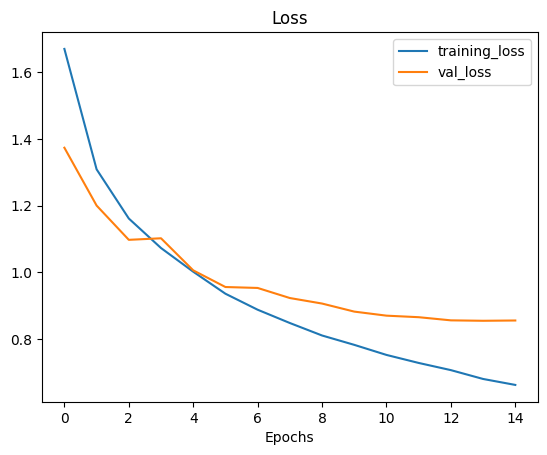

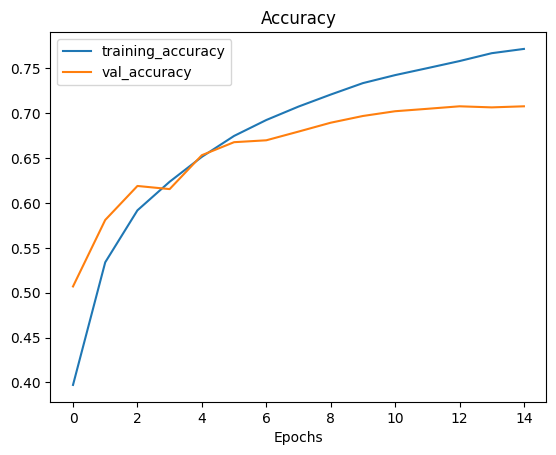

In [20]:
# Plotting the loss and accuracy 
plot_loss_curves(history=history)

In [21]:
cifar10_classes

['plane',
 'car',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

1/1 [==============================] - 0s 24ms/step


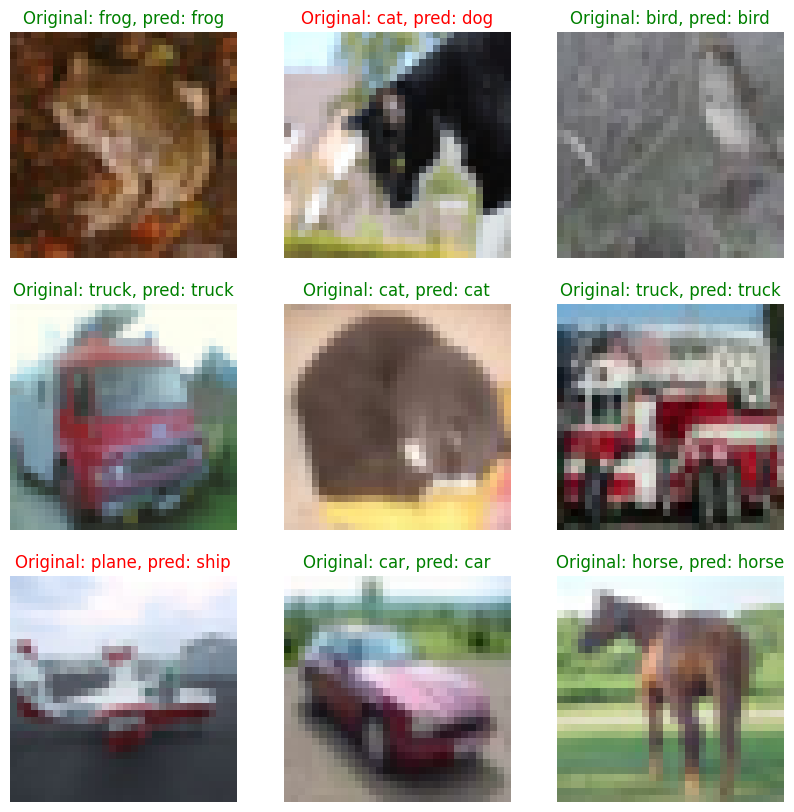

In [22]:
import random

plt.figure(figsize=(10,10))
for i in range(9):
    rand_index = random.randint(0,1000)
    sample = x_test[rand_index]
    sample = tf.expand_dims(sample, axis=0)
    original_class = cifar10_classes[y_test[rand_index]]
    prediction = model.predict(sample)
    pred_class = cifar10_classes[prediction.argmax()]
    
    plt.subplot(3, 3, i+1)
    plt.imshow(tf.squeeze(sample))
    if original_class != pred_class:
        title_color = "red"
    elif original_class == pred_class: 
        title_color = "green"
        
    plt.title(f"Original: {original_class}, pred: {pred_class}",color=title_color)
    plt.axis(False)

In [23]:
prediction = model.predict(x_test)


313/313 [==============================] - 2s 6ms/step


In [24]:
preds = tf.argmax(prediction, axis=1)
preds

<tf.Tensor: shape=(10000,), dtype=int64, numpy=array([3, 8, 8, ..., 5, 4, 7], dtype=int64)>

<AxesSubplot: >

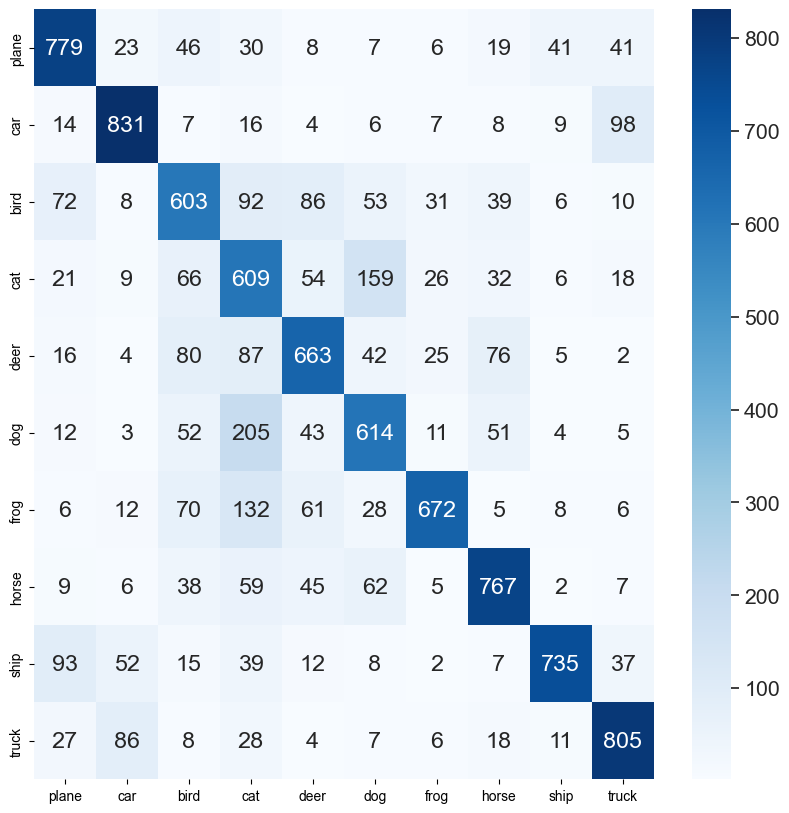

In [25]:
#Creating Confusion matrix

from sklearn.metrics import confusion_matrix
import seaborn as sn
cm = confusion_matrix(y_true=y_test, y_pred=preds)
plt.figure(figsize=(10,10))
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Original', fontsize=18)
sn.set(font_scale = 1.4)
sn.heatmap(cm, cmap="Blues", annot=True, fmt="d", xticklabels= cifar10_classes, yticklabels=cifar10_classes)


In [26]:
model.save("cifar10_model.hdf5")


In [28]:
# path = "images/"

# images = tf.keras.preprocessing.image_dataset_from_directory(path,
#                                                              labels=None,
#                                                              image_size=(32,32))
# images

In [29]:
# file_preds = model.predict(images)

In [30]:
# predictions = file_preds.argmax(axis=1)
# predictions